In [1]:
import xarray as xr
import pandas as pd

In [2]:
ZARR_PATH = "/mnt/storage_ssd_8tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/NWP/UK_Met_Office/UKV/zarr/UKV_intermediate_version_2.zarr"

## Load from Zarr

In [24]:
%%time
ds_from_zarr = xr.open_dataset(ZARR_PATH, mode="r", engine="zarr") #.sel(variable=['t', 'dswrf', 'prate', 'r', 'sde', 'si10', 'vis', 'lcc', 'mcc', 'hcc'])

CPU times: user 662 ms, sys: 87.3 ms, total: 749 ms
Wall time: 749 ms


In [25]:
ds_from_zarr

<xarray.Dataset>
Dimensions:    (variable: 17, init_time: 16008, step: 37, y: 704, x: 548)
Coordinates:
  * init_time  (init_time) datetime64[ns] 2016-03-22T15:00:00 ... 2021-10-16T...
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * variable   (variable) <U6 'cdcb' 'lcc' 'mcc' ... 'wdir10' 'prmsl' 'prate'
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 -183000 -181000 -179000 ... 1219000 1221000 1223000
Data variables:
    UKV        (variable, init_time, step, y, x) float32 ...

Variables perhaps to avoid:

hcct?  Looks like a static map of the UK?

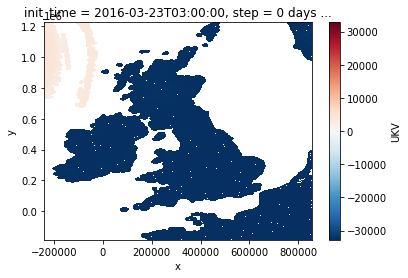

In [6]:
ds_from_zarr.sel(variable='si10').isel(init_time=4, step=3)['UKV'].plot.imshow()

False


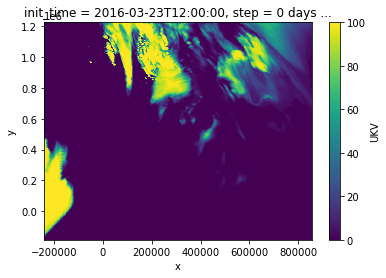

In [7]:
VARIABLE = "hcc"

print(ds_from_zarr['UKV'].sel(variable=VARIABLE).isel(step=0, init_time=7).isnull().any().values)

ds_from_zarr['UKV'].sel(variable=VARIABLE).isel(step=0, init_time=7).plot.imshow()

In [8]:
ds_from_zarr['UKV'].encoding

{'chunks': (17, 1, 1, 352, 274),
 'preferred_chunks': {'variable': 17,
  'init_time': 1,
  'step': 1,
  'y': 352,
  'x': 274},
 'compressor': Blosc(cname='zstd', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'dtype': dtype('float32')}

In [9]:
from nowcasting_dataset.data_sources import NWPDataSource

In [10]:
nwp_ds = NWPDataSource(history_minutes=60, forecast_minutes=120, channels=['t'], zarr_path=ZARR_PATH, image_size_pixels=64)

In [11]:
nwp_ds.open()

NWP y axis runs from bottom-to-top.  Will reverse y axis so it runs top-to-bottom.
NWP Zarr has 6 duplicated init_times.  Fixing...
NWP Zarr init_time is not monotonic_increasing.  Fixing...


In [12]:
nwp_ds._data

<xarray.DataArray 'UKV' (variable: 1, init_time: 15990, step: 37, y: 704, x: 548)>
[228246120960 values with dtype=float32]
Coordinates:
  * y          (y) int64 1223000 1221000 1219000 ... -179000 -181000 -183000
  * init_time  (init_time) datetime64[ns] 2016-03-22T15:00:00 ... 2021-10-16T...
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * variable   (variable) <U6 't'
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_edition:            2
    GRIB_subCentre:          0
    institution:             U.K. Met Office - Exeter

In [16]:
ds_from_zarr['UKV'].reindex({'variable': ['dswrf', 'prate']})

<xarray.DataArray 'UKV' (variable: 2, init_time: 16008, step: 37, y: 704, x: 548)>
[457006116864 values with dtype=float32]
Coordinates:
  * variable   (variable) <U5 'dswrf' 'prate'
  * init_time  (init_time) datetime64[ns] 2016-03-22T15:00:00 ... 2021-10-16T...
  * step       (step) timedelta64[ns] 00:00:00 01:00:00 ... 1 days 12:00:00
  * x          (x) int64 -239000 -237000 -235000 ... 851000 853000 855000
  * y          (y) int64 -183000 -181000 -179000 ... 1219000 1221000 1223000
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_edition:            2
    GRIB_subCentre:          0
    institution:             U.K. Met Office - Exeter

In [19]:
(ds_from_zarr['UKV']['variable'] == ds_from_zarr['UKV']['variable']).all()

<xarray.DataArray 'variable' ()>
array(True)